In [30]:
from mpi4py import MPI
from dolfinx import mesh
from dolfinx import fem
from dolfinx import cpp
from matplotlib import pyplot as plt
import numpy as np
import ufl

In [31]:
nx = 5
domain = mesh.create_interval(MPI.COMM_WORLD,5,(0,1))
V = fem.FunctionSpace(domain, ("CG", 1))
uD = fem.Function(V)
a1 =1/0.13386560424545213
uD.interpolate(lambda x: -a1*(x[0]**3-x[0]**2) )


In [32]:
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [33]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Function(V)
f.interpolate(lambda x: a1*(x[0]*6-2))

In [34]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx
problem = fem.petsc.LinearProblem(a, L,bcs=[bc],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [35]:
x = V.tabulate_dof_coordinates()[:,0]

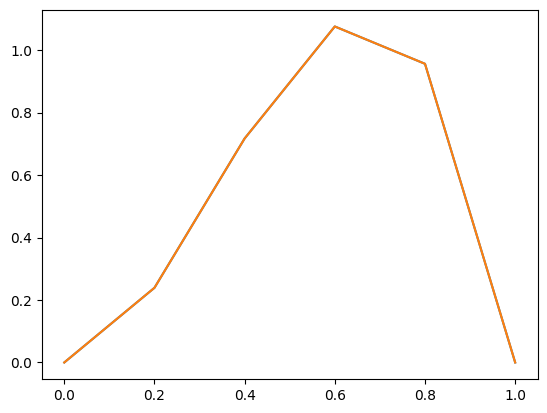

In [36]:
plt.plot(x,uh.x.array)
plt.plot(x,uD.x.array)

In [37]:
print(uh.x.array)
print(uD.x.array)

[-0.          0.23904572  0.71713717  1.07570575  0.95618289 -0.        ]
[-0.          0.23904572  0.71713717  1.07570575  0.95618289 -0.        ]


In [38]:

h=1/nx
print(h*problem.A.getValues(range(nx+1),range(nx+1)))

[[ 0.2  0.   0.   0.   0.   0. ]
 [ 0.   2.  -1.   0.   0.   0. ]
 [ 0.  -1.   2.  -1.   0.   0. ]
 [ 0.   0.  -1.   2.  -1.   0. ]
 [ 0.   0.   0.  -1.   2.   0. ]
 [ 0.   0.   0.   0.   0.   0.2]]


In [26]:
print(problem.b.getArray())

[-0.         -1.19522861  0.5976143   2.39045722  4.18330013 -0.        ]


In [27]:

print(h*problem.b.getArray())

[-0.         -0.23904572  0.11952286  0.47809144  0.83666003 -0.        ]


In [39]:
modified_b =h*a1*h*(6*h*np.arange(1,nx)-2)
print(modified_b)
print(np.linalg.norm(modified_b))

[-0.23904572  0.11952286  0.47809144  0.83666003]
1.0000000000000002
